Reading input image input_image.png
Input image resolution is (1080, 1920, 4)
Input image is:


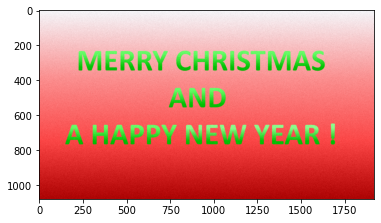

Reading letters data
Reading input image template.png
Applying median filter
Image after applying median filter is:


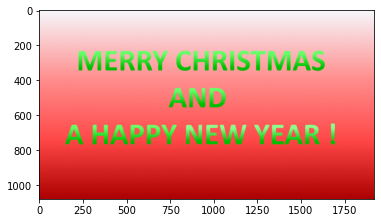

Converting from RGB to HSV


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image after applying RGB2HSV is:


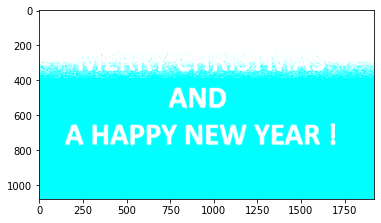

Finding bounding segments
Computing limits on each dimension for each found segment
Image after applying segmentation is:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


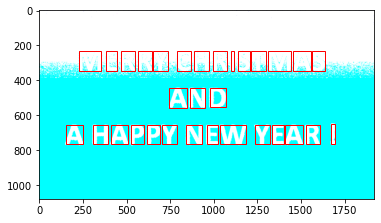

Matching letters from input image to template image
Message found:
C S SM ERRY HRKTMA AND !A HAPPYNEW YEAR

In [83]:
# Sisteme de Prelucrare Grafica - Tema 3 - Mini OCR
# Grigore Lucian-Florin 343C4


import os
from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt


def readimage(filename):
    print(f'Reading input image {filename}')
    return imread(filename)


# 1. Median filter
def med(image, x, y, channel):
    lst = []
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            lst.append(image[i][j][channel])
    lst.sort()
    return lst[4]


def medflt(image):
    print('Applying median filter')
    for i in range(1, len(image) - 1):
        for j in range(1, len(image[i]) - 1):
            for k in range(3):
                image[i][j][k] = med(image, i, j, k)
    return image


# 2. RGB to HSV
def rgb2hsv(image):
    print('Converting from RGB to HSV')
    new_image = [[[0 for _ in range(3)] for _ in range(len(image[0]))] for _ in range(len(image))]
    for i in range(len(image)):
        for j in range(len(image[i])):
            r, g, b = image[i][j][:-1]
            mx = max(r, g, b)
            mn = min(r, g, b)   
            df = mx - mn
            if mx == mn:
                h = 0
            elif mx == r:
                h = (60 * ((g - b) / df) + 360) % 360
            elif mx == g:
                h = (60 * ((b - r) / df) + 120) % 360
            elif mx == b:
                h = (60 * ((r - g) / df) + 240) % 360
            if mx == 0:
                s = 0
            else:
                s = (df / mx) * 100
            v = mx*100
            new_image[i][j][0] = h
            new_image[i][j][1] = s
            new_image[i][j][2] = v
    return new_image


# 3. Region growing segmentation
def isgreen(pixel):
    return pixel[0] >= 85 and pixel[0] <= 150 and pixel[1] >= 25 and pixel[2] >= 5


def bfs(image, regions, visited_matrix, id, x, y):
    from collections import deque
    region = []
    q = deque()
    q.appendleft((x, y))

    while q:
        crt_x, crt_y = q.pop()
        region.append((crt_x, crt_y))
        visited_matrix[crt_x][crt_y] = 1

        for i in range(crt_x - 1, crt_x + 2):
            for j in range(crt_y - 1, crt_y + 2):
                if isgreen(image[i][j]) and visited_matrix[i][j] == 0 and (i, j) not in q:
                    q.appendleft((i, j))

    regions[id] = region
    return image, regions, visited_matrix


def segimg(image):
    print('Finding bounding segments')
    regions, crt_id, visited_matrix = {}, 0, [[0 for _ in range(1920)] for _ in range(1080)]
    for i in range(len(image)):
        for j in range(len(image[i])):
            if isgreen(image[i][j]) and visited_matrix[i][j] == 0:
                image, regions, visited_matrix = bfs(image, regions, visited_matrix, crt_id, i, j)
                crt_id += 1
    return image, regions


# 4. Finding boxes
def findboxes(regions):
    print('Computing limits on each dimension for each found segment')
    boxes = {}
    regions_sorted = sorted(regions)
    for k in regions_sorted:
        v = regions[k]
        crt_max_x, crt_max_y, crt_min_x, crt_min_y = -1, -1, 10000, 10000
        for i in range(len(v)):
            if v[i][0] > crt_max_x:
                crt_max_x = v[i][0]
            elif v[i][0] < crt_min_x:
                crt_min_x = v[i][0]
            if v[i][1] > crt_max_y:
                crt_max_y = v[i][1]
            elif v[i][1] < crt_min_y:
                crt_min_y = v[i][1]
        boxes[k] = (crt_min_x, crt_min_y, crt_max_x, crt_max_y)
    return boxes

# 4.1 Order boxes to fit the order from input image
def orderboxes(boxes):
    ordered_boxes = {}
    vals = list(boxes.values())
    vals = sorted(vals, key=lambda x: x[0] + x[1] + x[2] + x[3])
    for i in range(len(vals)):
        ordered_boxes[i] = vals[i]
    return ordered_boxes

# 5. Matching letters
def matchletters(image, boxes, letters, template):
    print('Matching letters from input image to template image')
    found_letters = {}
    boxes_sorted = sorted(boxes)
    crt_id = 0
    for id in boxes_sorted:
        bounds = boxes[id]
        dim_x, dim_y = bounds[2] - bounds[0], bounds[3] - bounds[1]
        crt_letter, crt_max_match = '.', -1
        if id != 0:
            if bounds[0] > boxes[id - 1][0] + 100 or bounds[1] > boxes[id - 1][1] + 150:
                found_letters[crt_id] = ' '
                crt_id += 1
        for letter, init_letter_pos in letters.items():
            crt_match = 0
            for i in range(bounds[0], bounds[2] + 1):
                for j in range(bounds[1], bounds[3] + 1):
                    template_x, template_y = int(init_letter_pos[0]) + (j - bounds[1]), int(init_letter_pos[1]) + (i - bounds[0])
                    if isgreen(image[i][j]) and template[template_y][template_x][0] >= 0.8:
                        crt_match += 1
            if crt_match > crt_max_match:
                crt_max_match = crt_match
                crt_letter = letter
        found_letters[crt_id] = crt_letter
        crt_id += 1
    return found_letters


# 6. Printing found message
def printmsg(found_letters):
    print('Message found:')
    for idx in sorted(found_letters):
        print(found_letters[idx], end='')


# OCR
input_image = readimage('input_image.png')
print(f'Input image resolution is {input_image.shape}')
print('Input image is:')
plt.figure()
plt.imshow(input_image)
plt.show()
print('Reading letters data')
template_image = readimage('template.png')
letters = {}
with open('letters.txt', 'r') as f:
    for line in f:
        s = line.split(' ')
        letters[s[0]] = (s[1], s[2].strip())
input_image = medflt(input_image)
print('Image after applying median filter is:')
plt.figure()
plt.imshow(input_image)
plt.show()
input_image = rgb2hsv(input_image)
print('Image after applying RGB2HSV is:')
plt.figure()
plt.imshow(input_image)
plt.show()
input_image, regions = segimg(input_image)
boxes = findboxes(regions)
# boxes = orderboxes(boxes)
print('Image after applying segmentation is:')
plt.figure()
plt.imshow(input_image)
ax = plt.gca()
for k, v in boxes.items():
    rect = plt.Rectangle((v[1], v[0]), v[3] - v[1], v[2] - v[0], facecolor='none', edgecolor='r')
    ax.add_patch(rect)
plt.show()
found_letters = matchletters(input_image, boxes, letters, template_image)
printmsg(found_letters)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


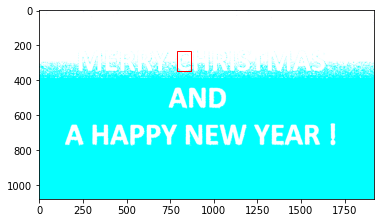

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


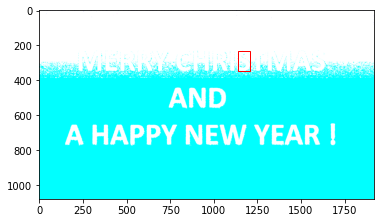

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


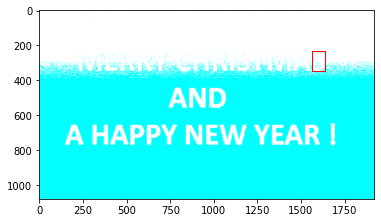

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


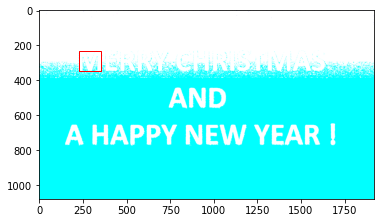

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


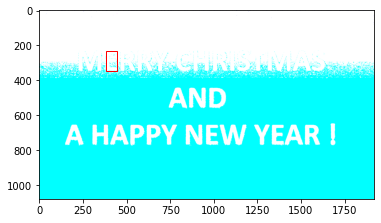

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


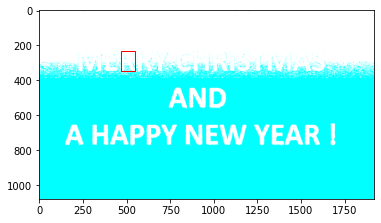

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


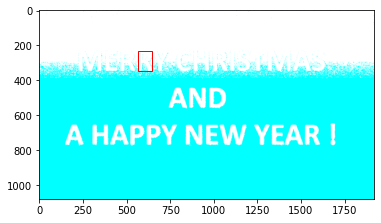

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


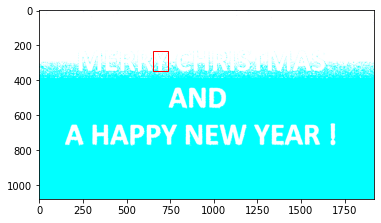

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


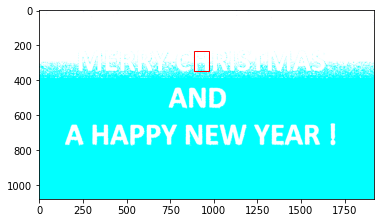

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


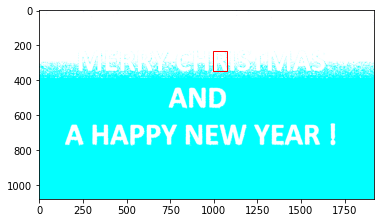

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


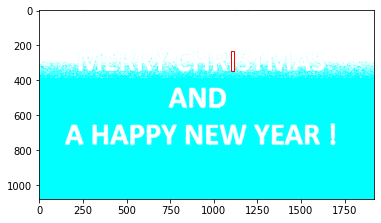

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


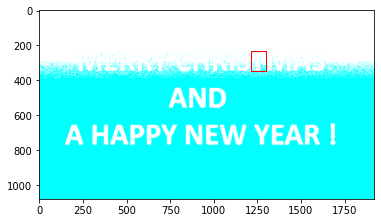

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


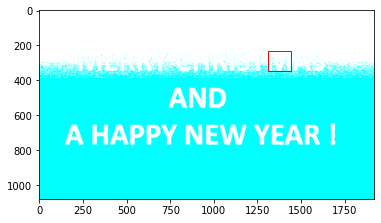

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


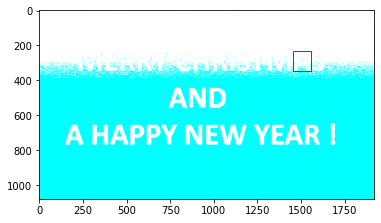

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


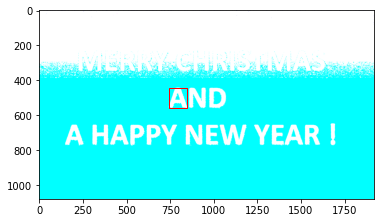

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


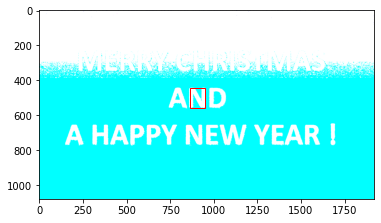

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


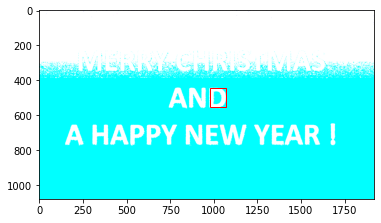

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


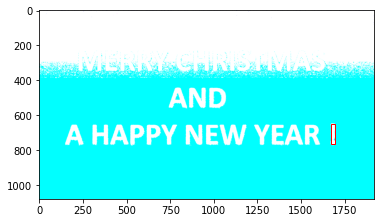

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


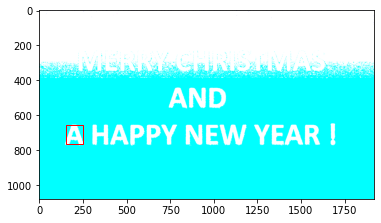

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


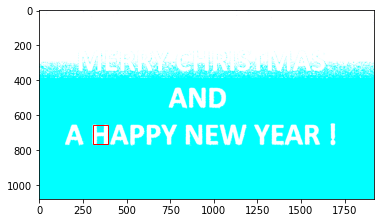

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


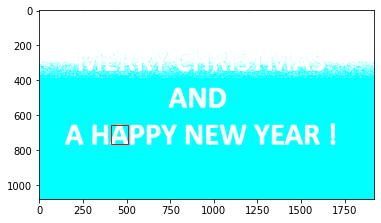

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


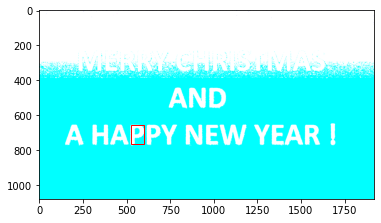

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


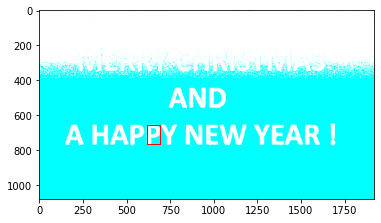

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


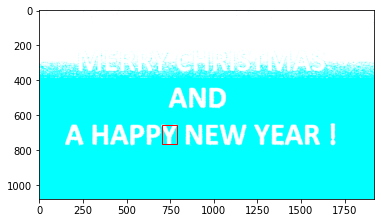

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


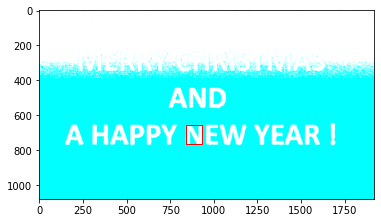

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


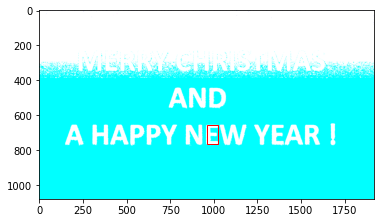

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


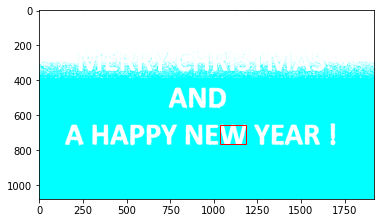

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


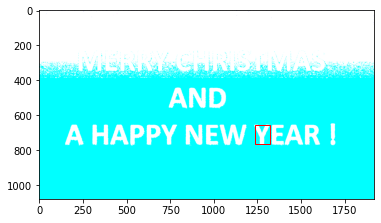

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


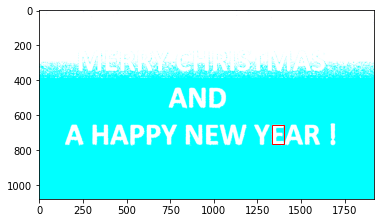

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


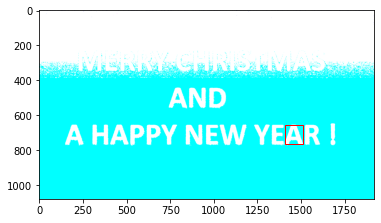

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


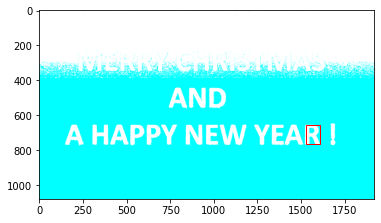

In [84]:
for k, v in boxes.items():
    plt.figure()
    ax = plt.gca()
    plt.imshow(input_image)
    ax.add_patch(plt.Rectangle((v[1], v[0]), v[3] - v[1], v[2] - v[0], facecolor='none', edgecolor='r'))
    plt.show()